In [ ]:
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install qiskit_algorithms
# %pip install qiskit_aer
# %pip install datasets
# %pip install 'accelerate>=0.26.0'
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install torch
# %pip install transformers
# %pip install scikit-learn
# %pip install datasets
# %pip install kagglehub
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install qiskit_algorithms
# %pip install ipywidgets
# %pip install pylatexenc


In [1]:
import pickle
import os
import gc
import hashlib
from IPython.display import clear_output, display
from collections import Counter
import collections
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from datasets import Dataset
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, noise
from qiskit.circuit import Parameter
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit import QuantumCircuit
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from sklearn.multiclass import OneVsRestClassifier
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms import PegasosQSVC
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.circuit.library import ZZFeatureMap
from qiskit_ibm_runtime import Batch
from qiskit.primitives import Sampler
from joblib import Parallel, delayed
import kagglehub
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 12345

##### Load and Prepare Dataset

#### Dataset from https://www.kaggle.com/datasets/lizhecheng/llm-science-dataset

In [2]:
file_path = kagglehub.dataset_download("lizhecheng/llm-science-dataset")
data = pd.read_csv(f"{file_path}/High Quality Dataset.csv")
data.columns = data.columns.str.strip()
data['answer'] = data['answer'].str.strip().str.upper()
label_to_id = {label: idx for idx, label in enumerate(sorted(data['answer'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
data['label'] = data['answer'].map(label_to_id)

def format_prompt_with_correct_answer(row):
    option_letter = row['answer']
    if option_letter in ['A', 'B', 'C', 'D', 'E']:
        correct_text = row.get(option_letter, '[Missing]')
        return f"{row['prompt']}\nCorrect: {option_letter}: {correct_text}"
    else:
        return f"{row['prompt']}\nCorrect: {option_letter}: [Invalid answer]"

data['full_prompt'] = data.apply(format_prompt_with_correct_answer, axis=1)
label_counts = Counter(data['label'])
valid_labels = [label for label, count in label_counts.items() if count > 1]
data = data[data['label'].isin(valid_labels)]

train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

In [3]:
X_train = train_df['full_prompt'].values
y_train = train_df['label'].values
X_test = test_df['full_prompt'].values
y_test = test_df['label'].values

##### TF-IDF features

In [4]:
tfidf = TfidfVectorizer(max_features=200)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

n_dimensions = 3
pca = PCA(n_components=n_dimensions)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

##### Reduce dimensions for quantum kernel

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)
pca = PCA(n_components=3)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

##### Quantum kernel training on a small subset

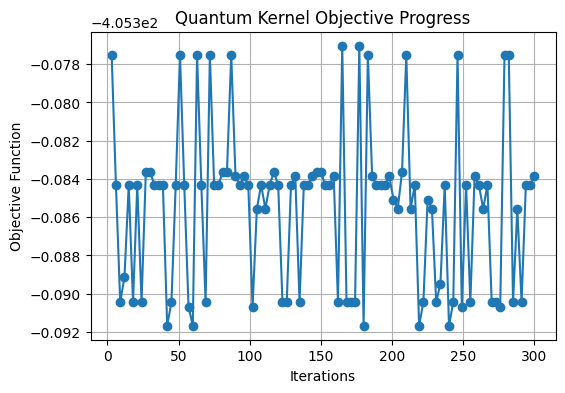

In [6]:
X_train_quantum = X_train_reduced[:100]
y_train_quantum = y_train[:100]

num_qubits = 3
num_features = X_train_reduced.shape[1]
layers = num_features // num_qubits
x_params = [Parameter(f"x[{i}]") for i in range(num_features)]
theta_params = [Parameter(f"θ[{i}]") for i in range(num_qubits * layers)]

def conv_layer(num_qubits, label, params):
    qc = QuantumCircuit(num_qubits, name=label)
    for i in range(num_qubits):
        qc.rx(params[i], i)
    return qc

def pool_layer(qubits, label):
    qc = QuantumCircuit(len(qubits), name=label)
    for i in range(0, len(qubits) - 1, 2):
        qc.cx(qubits[i], qubits[i + 1])
    return qc

def build_ansatz(num_qubits, x_params, theta_params, layers):
    ansatz = QuantumCircuit(num_qubits, name="Ansatz")
    theta_iter = iter(theta_params)
    for layer in range(layers):
        x_slice = x_params[layer * num_qubits:(layer + 1) * num_qubits]
        for i in range(num_qubits):
            ansatz.rx(x_slice[i], i)
        conv_params = [next(theta_iter) for _ in range(num_qubits)]
        ansatz.compose(conv_layer(num_qubits, f"θ_c{layer+1}", conv_params), inplace=True)
        ansatz.compose(pool_layer(range(num_qubits), f"p{layer+1}"), inplace=True)
    return ansatz

class QKTCallback:
    def __init__(self):
        self._data = [[] for _ in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

        if x2 is not None:
            clear_output(wait=True)
            plt.figure(figsize=(6, 4))
            plt.plot(self._data[0], self._data[2], marker='o')
            plt.title("Quantum Kernel Objective Progress")
            plt.xlabel("Iterations")
            plt.ylabel("Objective Function")
            plt.grid(True)
            display(plt.gcf())
            plt.close()

    def get_callback_data(self):
        return self._data
    
    def clear_callback_data(self):
        self._data = [[] for i in range(5)]


cb_qkt = QKTCallback()
ansatz = build_ansatz(num_qubits, x_params, theta_params, layers)
backend = AerSimulator(method='density_matrix')
fidelity = ComputeUncompute(sampler=Sampler())
spsa_opt = SPSA(maxiter=100, callback=cb_qkt.callback, learning_rate=0.0001, perturbation=0.0001)

qkt = QuantumKernelTrainer(
    quantum_kernel=TrainableFidelityQuantumKernel(
        fidelity=fidelity,
        feature_map=ansatz,
        training_parameters=theta_params,
    ),
    loss=SVCLoss(),
    optimizer=spsa_opt,
    initial_point=np.random.randn(len(theta_params)) * 0.1,
)

print("Training quantum kernel on subset...")
result = qkt.fit(X_train_quantum, y_train_quantum)
kernel = result.quantum_kernel

##### Tokenization

In [7]:
tokenizer = TfidfVectorizer(max_features=100, token_pattern=r"(?u)\b\w+\b")
tfidf_train = tokenizer.fit_transform(X_train)
tfidf_test = tokenizer.transform(X_test)

X_train_tensor = torch.tensor(tfidf_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(tfidf_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

##### Evaluate quantum kernel

In [8]:
X_train_slice = X_train_tensor[:1000]
y_train_slice = y_train_tensor[:1000]
X_test_slice = X_test_tensor[:200]
y_test_slice = y_test_tensor[:200]
X_train_reduced_slice = X_train_reduced[:1000]
X_test_reduced_slice = X_test_reduced[:200]

def eval_kernel_row(i, data, ref):
    return kernel.evaluate([data[i]], ref)[0]

q_train = np.array(thread_map(lambda i: eval_kernel_row(i, X_train_reduced_slice, X_train_reduced_slice), range(1000)))
q_test = np.array(thread_map(lambda i: eval_kernel_row(i, X_test_reduced_slice, X_train_reduced_slice), range(200)))

q_train_tensor = torch.tensor(q_train, dtype=torch.float32)
q_test_tensor = torch.tensor(q_test, dtype=torch.float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
q_pca = PCA(n_components=100)
q_train_reduced = q_pca.fit_transform(q_train)
q_test_reduced = q_pca.transform(q_test)

q_train_tensor = torch.tensor(q_train_reduced, dtype=torch.float32)
q_test_tensor = torch.tensor(q_test_reduced, dtype=torch.float32)

In [10]:
X_train_final = torch.cat((X_train_slice, q_train_tensor), dim=1)
X_test_final = torch.cat((X_test_slice, q_test_tensor), dim=1)

In [11]:
train_dataset = TensorDataset(X_train_final, y_train_slice)
test_dataset = TensorDataset(X_test_final, y_test_slice)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
full_weights = np.zeros(len(label_to_id), dtype=np.float32)
for i, class_idx in enumerate(np.unique(y_train)):
    full_weights[class_idx] = class_weights[i]
weights_tensor = torch.tensor(full_weights, dtype=torch.float32)

##### Model Definition

In [12]:
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=0.2),
            num_layers=2
        )
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids.float())
        x = x.unsqueeze(1)
        x = x + self.pos_embedding[:, :1, :]
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.classifier(x)

##### Training Setup

In [13]:
device = torch.device("mps" if torch.has_mps else "cpu")
model = SimpleTransformer(
    input_dim=200,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_classes=len(label_to_id)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor.to(device))

##### Training Loop

In [14]:
train_history = {'loss': [], 'accuracy': []}
model.train()

print("🚀 Training Simple Transformer (TF-IDF + Quantum)...")

for epoch in range(20):
    total_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = output.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{(correct / total):.4f}"})

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / total
    train_history['loss'].append(avg_loss)
    train_history['accuracy'].append(avg_acc)
    print(f"✅ Epoch {epoch} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")

🚀 Training Simple Transformer (TF-IDF + Quantum)...


✅ Epoch 0 | Loss: 1.6595 | Accuracy: 0.2080


✅ Epoch 1 | Loss: 1.6527 | Accuracy: 0.2040


✅ Epoch 2 | Loss: 1.6418 | Accuracy: 0.2110


✅ Epoch 3 | Loss: 1.6152 | Accuracy: 0.2220


✅ Epoch 4 | Loss: 1.5985 | Accuracy: 0.2510


✅ Epoch 5 | Loss: 1.5443 | Accuracy: 0.2960


✅ Epoch 6 | Loss: 1.2826 | Accuracy: 0.4780


✅ Epoch 7 | Loss: 0.7872 | Accuracy: 0.7160


✅ Epoch 8 | Loss: 0.4544 | Accuracy: 0.8260


✅ Epoch 9 | Loss: 0.2646 | Accuracy: 0.9110


✅ Epoch 10 | Loss: 0.1643 | Accuracy: 0.9460


✅ Epoch 11 | Loss: 0.2278 | Accuracy: 0.9190


✅ Epoch 12 | Loss: 0.1381 | Accuracy: 0.9470


✅ Epoch 13 | Loss: 0.0610 | Accuracy: 0.9870


✅ Epoch 14 | Loss: 0.1113 | Accuracy: 0.9580


✅ Epoch 15 | Loss: 0.0994 | Accuracy: 0.9700


✅ Epoch 16 | Loss: 0.0924 | Accuracy: 0.9680


✅ Epoch 17 | Loss: 0.0381 | Accuracy: 0.9890


✅ Epoch 18 | Loss: 0.0529 | Accuracy: 0.9790


✅ Epoch 19 | Loss: 0.0488 | Accuracy: 0.9860


##### Plot Evaluation

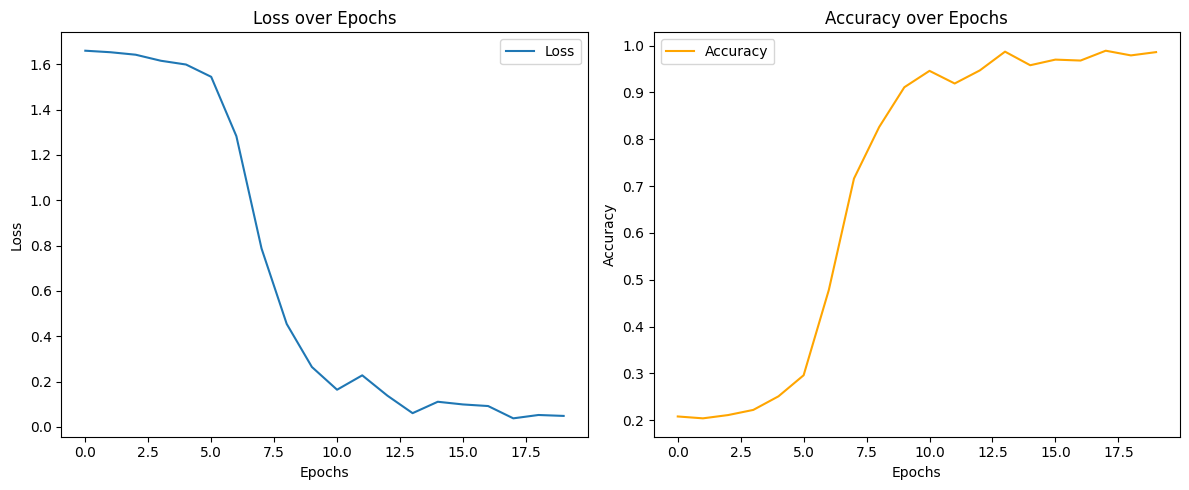

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##### Evaluation Preparation

In [18]:
model.eval()
X_sample, y_sample = next(iter(train_loader))
with torch.no_grad():
    outputs = model(X_sample.to(device))
    preds = outputs.argmax(dim=1)
    acc = (preds == y_sample.to(device)).float().mean().item()
print(f"🔍 Sample Accuracy: {acc:.4f}")
print("Predicted:", preds.cpu().numpy()[:10])
print("True     :", y_sample.numpy()[:10])

🔍 Sample Accuracy: 1.0000
Predicted: [0 3 0 4 0 4 0 2 0 0]
True     : [0 3 0 4 0 4 0 2 0 0]


##### Evaluation Metrics

In [19]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_final.to(device)
    y_test_tensor = y_test_slice.to(device)
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

print(f"Test Accuracy: {metrics.accuracy_score(y_true, y_pred):.4f}")
print("📋 Classification Report:")
target_names = [id_to_label[i] for i in sorted(set(y_true) | set(y_pred))]
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

Test Accuracy: 0.9500
📋 Classification Report:
              precision    recall  f1-score   support

           A       0.96      0.90      0.93        50
           B       0.88      0.98      0.92        44
           C       0.97      0.97      0.97        30
           D       0.98      0.95      0.96        42
           E       1.00      0.97      0.99        34

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



##### Confusion Matrix

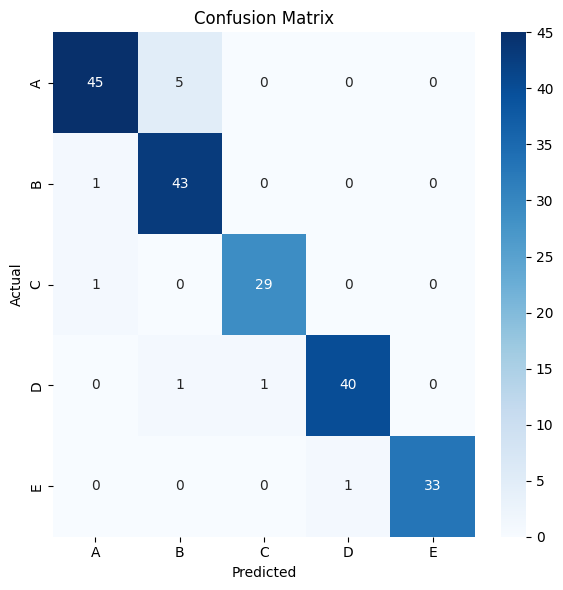

In [20]:
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id_to_label[i] for i in sorted(label_to_id.values())],
            yticklabels=[id_to_label[i] for i in sorted(label_to_id.values())])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [21]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright